# Portfolio Optimization Project

This project aims to analyze and optimize a portfolio consisting of six major US technology stocks: Apple, Microsoft, Google, Nvidia, Tesla, and Meta.

The main objectives are:

- Download and process historical financial data for selected assets  
- Compute expected annual returns and the covariance matrix of returns  
- Visualize the risk-return characteristics of individual assets  
- Construct the **Global Minimum Variance Portfolio (GMVP)**  
- Construct the **Tangency Portfolio** that maximizes the Sharpe Ratio  
- Plot the **Efficient Frontier** and the **Capital Allocation Line (CAL)**  
- Compare Sharpe Ratios of GMVP and Tangency Portfolio  
- Solve for the optimal portfolio that achieves a specified target return with minimum risk

The analysis is based on **Modern Portfolio Theory (Markowitz framework)** and uses **historical return data** with a proxy for the **risk-free rate** from US 10-year Treasury yields.

This notebook provides both **quantitative results** (weights, Sharpe Ratios, returns, risk) and **visual insights** (efficient frontier, CAL, pie charts) to support investment decisions.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.optimize as spop

## Loading Historical Price Data

We select 6 large-cap US tech stocks as our investment universe. Using the `yfinance` API, we download 10 years of historical daily closing prices.

This data will be used to compute daily returns for each asset, which are the basis for portfolio return and risk calculations.


In [2]:
# Load Historical Data
# Define list of stock tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'TSLA', 'META']

# Download historical closing price data (last 10 years)
data = yf.download(tickers, start='2015-05-01', end='2025-05-01')['Close']
data.index.name = None
# Calculate daily returns
returns_df = data.pct_change().dropna()
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,GOOGL,META,MSFT,NVDA,TSLA
2015-05-01,28.798101,27.426874,78.619453,41.997139,0.548079,15.068667
2015-05-04,28.742271,27.510475,78.440300,41.634659,0.544706,15.367333
2015-05-05,28.094620,27.022804,77.196175,41.082310,0.530733,15.530000
2015-05-06,27.918194,26.626698,77.733635,39.943039,0.532419,15.362000
2015-05-07,28.090872,26.973042,78.062103,40.305534,0.541815,15.786667
...,...,...,...,...,...,...
2025-04-24,208.369995,159.279999,533.150024,387.299988,106.430000,259.510010
2025-04-25,209.279999,161.960007,547.270020,391.850006,111.010002,284.950012
2025-04-28,210.139999,160.610001,549.739990,391.160004,108.730003,285.880005
2025-04-29,211.210007,160.160004,554.440002,394.040009,109.019997,292.029999


## Loading and Estimating the Risk-Free Rate

As a proxy for the risk-free rate, we use the 10-year US Treasury yield (symbol: `^TNX`). We take the average of the last 10 years of daily yields and convert it to a decimal.

This will be used for Sharpe ratio and capital allocation line (CAL) calculations.


In [3]:
# Load Risk-Free Rate Data
# Download 10-year US Treasury yield data (as a proxy for the risk-free rate)
rf_data = yf.download('^TNX', start='2015-05-01', end='2025-05-01')['Close']

# Calculate average annualized yield and convert to decimal
rf = rf_data.mean() / 100
rf = rf.iloc[0]
rf

[*********************100%***********************]  1 of 1 completed


0.025569093068772683

In [4]:
#calculating the return vector and the covariance matrix
cov = returns_df.cov() * 252
r = np.array(((1 + returns_df).prod())**(252 / len(returns_df)) - 1)
e = np.ones(len(r))
r

array([0.22181842, 0.19247544, 0.21508224, 0.25198376, 0.69971055,
       0.3413612 ])

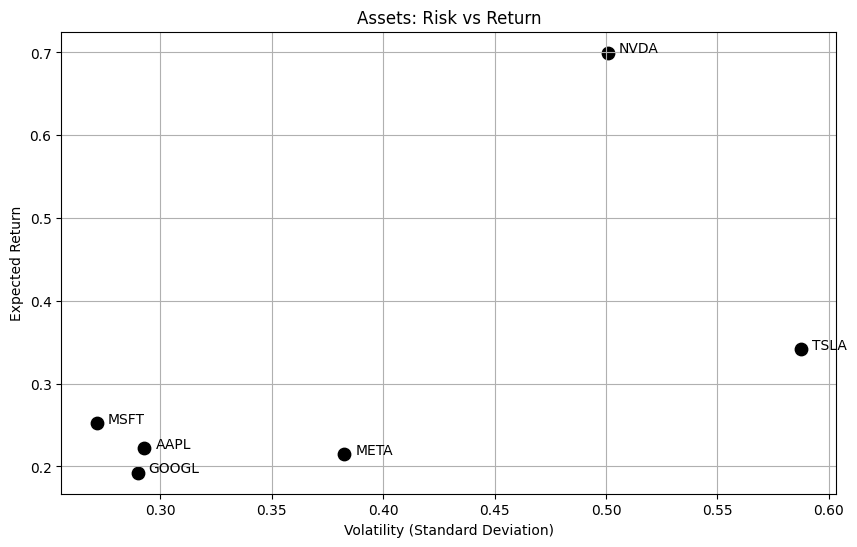

In [5]:
# Scatter plot of expected return vs standard deviation for each asset
asset_returns = r
asset_vols = np.sqrt(np.diag(cov))

plt.figure(figsize=(10, 6))
plt.scatter(asset_vols, asset_returns, c='black', s=80)

# Labeling each point
for i, txt in enumerate(returns_df.columns):
    plt.annotate(txt, (asset_vols[i]+0.005, asset_returns[i]), fontsize=10)

plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Expected Return")
plt.title("Assets: Risk vs Return")
plt.grid(True)
plt.show()

### Observations from Asset Risk vs Return Plot

This scatter plot shows the annualized expected return versus volatility for each of the six assets in the portfolio.

#### Key Insights:
- **NVIDIA (NVDA)** stands out with the **highest expected return**, but also exhibits high volatility — a classic high-risk, high-return profile.
- **Tesla (TSLA)** also shows high volatility, with a return lower than NVDA, suggesting higher risk with relatively less compensation.
- **Microsoft (MSFT)** and **Apple (AAPL)** offer **moderate returns at relatively low risk**, which may make them stable components in an optimized portfolio.
- **Google (GOOGL)** has the **lowest expected return**, but its low volatility might still make it useful for diversification.
- **Meta (META)** lies somewhere in between with average risk and return.

#### Implication for Optimization:
This visualization helps identify assets that may dominate others (e.g., NVDA may dominate TSLA) or complement each other through diversification. In subsequent steps, these differences will influence the shape of the efficient frontier and the composition of optimal portfolios like GMVP and the Tangency Portfolio.


In [6]:
# Compute Matrix Constants for Frontier
icov = np.linalg.inv(cov)
h = np.matmul(e, icov)
g = np.matmul(r, icov)
a = np.sum(e * h)
b = np.sum(e * g)
c = np.sum(r * g)
d = a * c - b**2


# Compute Minimum Variance and Tangency Portfolios
mvp = h / a
mvp_return = b / a
mvp_risk = 1 / np.sqrt(a)

In [7]:
#minimum variance and tangency portfolio
mvp = h/a
mvp_return = b/a
mvp_risk = 1/a**(1/2)

tangency = g/b 
tangency_return = c/b
tangency_risk = c**(1/2)/b
mvp

array([ 0.32405072,  0.30941811,  0.0094473 ,  0.47938419, -0.11494319,
       -0.00735714])

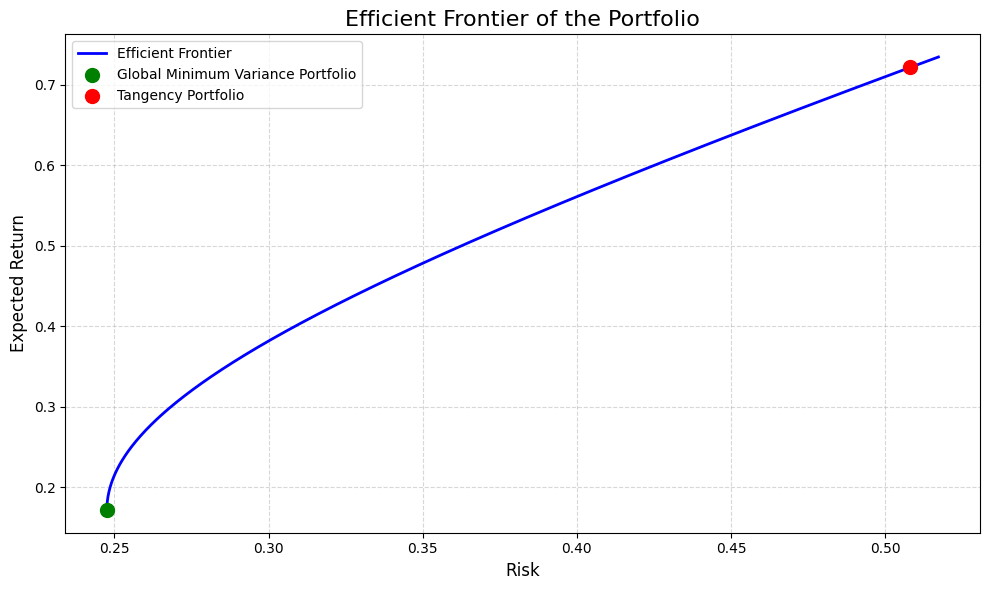

In [8]:
#plotting the efficient portfolio frontier
min_return = mvp_return               
max_return = np.max(r)*1.05   # reserve for better visualization          
exp_returns = np.linspace(min_return, max_return, 500)
risk = ((a*exp_returns**2 - 2*b*exp_returns + c)/d)**(1/2)

plt.figure(figsize=(10, 6))
plt.plot(risk, exp_returns, label='Efficient Frontier', color='blue', linewidth=2)
plt.scatter(mvp_risk, mvp_return, color='green', s=100, label='Global Minimum Variance Portfolio', zorder=5)
plt.scatter(tangency_risk, tangency_return, color='red', s=100, label='Tangency Portfolio', zorder=5)

plt.title('Efficient Frontier of the Portfolio', fontsize=16)
plt.xlabel('Risk', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.xlim
plt.ylim
plt.tight_layout()

plt.show()

### Efficient Frontier of the Portfolio

This plot presents the **Efficient Frontier**, which represents the set of optimal portfolios offering the **highest expected return for a given level of risk**. 

#### Highlights:
- The **green point** represents the **Global Minimum Variance Portfolio (GMVP)** — the portfolio with the lowest possible risk.
- The **red point** marks the **Tangency Portfolio**, which maximizes the Sharpe Ratio and lies on the Capital Market Line (CML) when the risk-free rate is introduced.

#### Methodological Note:
The frontier was computed using the mathematical framework of **Merton's portfolio theory**, which allowed us to analytically derive the optimal portfolio combinations based on the mean-variance characteristics of the assets. The calculations involve matrix algebra to determine key values used in the frontier's equation.

This efficient frontier serves as a foundation for making well-informed decisions about portfolio composition in the next steps of the analysis.


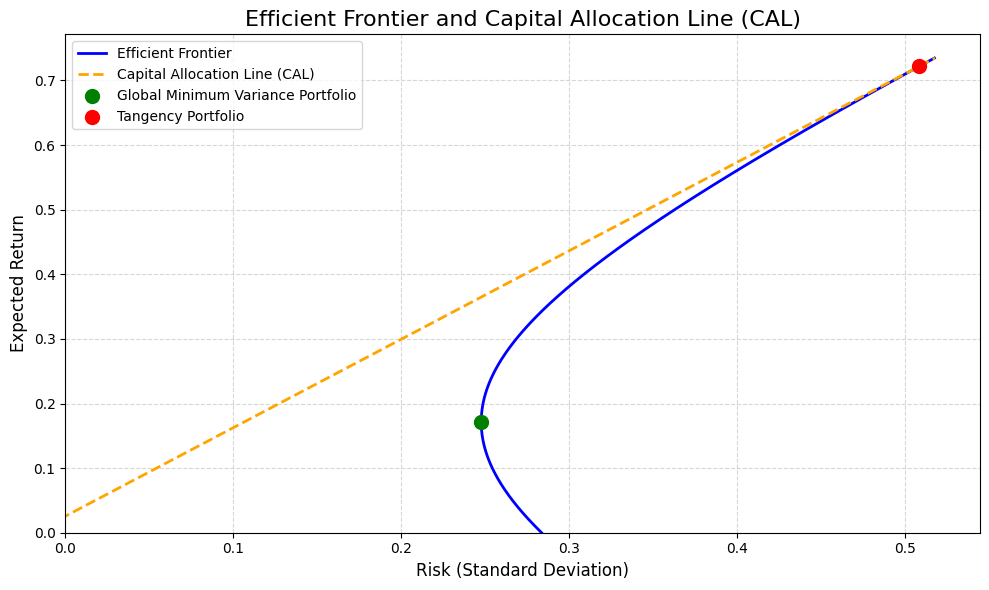

In [9]:
# Plot Capital Allocation Line (CAL)    
exp_returns = np.linspace(0, max_return, 500)
risk = ((a*exp_returns**2 - 2*b*exp_returns + c)/d)**(1/2)
CAL_slope = (tangency_return - rf) / tangency_risk 
CAL_risk = (exp_returns - rf) / CAL_slope

plt.figure(figsize=(10, 6))
plt.plot(risk, exp_returns, label='Efficient Frontier', color='blue', linewidth=2)
plt.plot(CAL_risk, exp_returns, label='Capital Allocation Line (CAL)', color='orange', linestyle='--', linewidth=2)
plt.scatter(mvp_risk, mvp_return, color='green', s=100, label='Global Minimum Variance Portfolio', zorder=5)
plt.scatter(tangency_risk, tangency_return, color='red', s=100, label='Tangency Portfolio', zorder=5)

plt.title('Efficient Frontier and Capital Allocation Line (CAL)', fontsize=16)
plt.xlabel('Risk (Standard Deviation)', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)

plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.tight_layout()

plt.show()

### Efficient Frontier and Capital Allocation Line (CAL)

This plot combines the **Efficient Frontier** with the **Capital Allocation Line (CAL)** to visualize how an investor can combine a risk-free asset with risky portfolios to achieve optimal performance.

#### Key Components:
- The **blue curve** shows the Efficient Frontier, representing optimal risky portfolios.
- The **orange dashed line** is the **Capital Allocation Line**, which starts at the risk-free rate and is tangent to the Efficient Frontier.
- The **red point** indicates the **Tangency Portfolio**, where the CAL touches the frontier. This portfolio offers the **highest Sharpe Ratio**, meaning the best risk-adjusted return.
- The **green point** shows the **Global Minimum Variance Portfolio**.

#### Assumptions:
To construct the CAL, we assumed a constant **risk-free rate of 2.56%**, based on the **average yield of the 10-Year US Treasury bond** over the analyzed 10-year period. This rate provides a realistic benchmark for a low-risk investment alternative in the model.

Thanks to the combination of risky and risk-free assets along the CAL, investors can select the portfolio that best matches their risk tolerance while remaining on the efficient frontier.


In [10]:
# Displaying weights in tabular format
weights_df = pd.DataFrame({
    'Asset': returns_df.columns,
    'GMVP Weights': mvp,
    'Tangency Weights': tangency
}).set_index('Asset')
weights_df.index.name = None
weights_df.style.format("{:.2%}")

,GMVP Weights,Tangency Weights
AAPL,32.41%,-0.40%
GOOGL,30.94%,-26.05%
META,0.94%,-17.84%
MSFT,47.94%,44.19%
NVDA,-11.49%,99.90%
TSLA,-0.74%,0.19%


In [11]:
# Calculating Sharpe Ratios for both MVP and Tangency Portfolio
sharpe_mvp = (mvp_return - rf) / mvp_risk
sharpe_tangency = (tangency_return - rf) / tangency_risk

print(f"Sharpe Ratio (MVP): {sharpe_mvp:.2f}")
print(f"Sharpe Ratio (Tangency): {sharpe_tangency:.2f}")

Sharpe Ratio (MVP): 0.59
Sharpe Ratio (Tangency): 1.37


### Portfolio Weights and Sharpe Ratios

#### Portfolio Composition:

- **Global Minimum Variance Portfolio (GMVP):**
  - Aims to minimize overall portfolio risk regardless of return.
  - Heavily weighted in **MSFT (47.94%)**, **AAPL (32.41%)**, and **GOOGL (30.94%)**.
  - Negative weights in **NVDA (-11.49%)** and **TSLA (-0.74%)** indicate short positions used to reduce risk further.

- **Tangency Portfolio:**
  - Designed to maximize the **Sharpe Ratio**, i.e., the best return per unit of risk.
  - Shows a strong concentration in **NVDA (99.90%)**, reflecting its high return-to-risk profile.
  - Short positions in **GOOGL (-26.05%)**, **META (-17.84%)**, and **AAPL (-0.40%)** indicate these assets were less efficient in terms of risk-adjusted return.

#### Sharpe Ratios:

- **Sharpe Ratio (GMVP):** 0.59 — indicates low returns with minimal risk.
- **Sharpe Ratio (Tangency Portfolio):** 1.37 — reflects a much higher risk-adjusted return, suggesting superior efficiency.

#### Insights:
The **Tangency Portfolio** is better suited for investors seeking optimal returns for the level of risk they are willing to take. In contrast, the **GMVP** is more appropriate for highly risk-averse investors who prioritize stability over high returns.


In [12]:
# Solver: portfolio with minimal risk for a target return (e.g., 12%)
target_return = 0.4  

# Formula from Merton's two-fund separation
z = (c - b*target_return) / d
y = (a*target_return - b) / d
target_weights = z * h + y * g

# Calculate stats for the target portfolio
target_portfolio_return = np.dot(target_weights, r)
target_portfolio_risk = np.sqrt(np.dot(target_weights, np.dot(cov, target_weights)))

print(f"Target Portfolio Return: {target_portfolio_return:.2%}")
print(f"Target Portfolio Risk: {target_portfolio_risk:.2%}")

Target Portfolio Return: 40.00%
Target Portfolio Risk: 30.87%


### Target Portfolio Optimization

Using Merton’s two-fund separation approach, we constructed a portfolio optimized to achieve a **target return of 40%**.

The resulting portfolio has:
- **Expected Return:** 40.00%
- **Estimated Risk (Standard Deviation):** 30.87%

This solution shows that if an investor desires a high return of 40%, it is indeed achievable through optimal asset allocation — but it comes with **substantial risk**. Such a portfolio would be suitable only for investors with a **very high risk tolerance**, as the volatility is significantly elevated.
